In [1]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline
from distfit import distfit
from scipy.stats import norm,dweibull
from keras.models import load_model
import pandas as pd
import numpy as np

In [2]:
from keras.layers import Dense,Conv1D,Convolution1D,Activation,MaxPooling1D,Flatten,Dropout

from keras.callbacks import TensorBoard
from keras import regularizers
#卷积神经网络
def creat_radio_model(input_dim):
    
    model=Sequential(name='radio_model')

    model.add(Dense(512,input_dim = input_dim,activation="relu"))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(1,activation = "linear"))

    model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])

    print(model.summary())
    return model


In [3]:
from keras import callbacks
tbCallBack = callbacks.TensorBoard(log_dir='Graph2', histogram_freq=0, write_graph=True, write_images=True)

In [4]:
import anndata
adata2=anndata.read_h5ad('tsp1_bladder_mesenchymeToMyofibroblast_forPaper.h5ad')
adata2

AnnData object with n_obs × n_vars = 3965 × 2000
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 'decontX_c

In [5]:
adata2_raw=anndata.read_h5ad('tsp1_bladder_raw.h5ad')
adata2_raw

AnnData object with n_obs × n_vars = 3795 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [10]:
adata2.obs['manual_annotation'].value_counts()


mesenchymal cell 2    1866
myofibroblast cell    1241
mesenchymal cell 1     836
mesenchymal cell 3      22
Name: manual_annotation, dtype: int64

In [12]:
adata2_raw.obs['cell_ontology_class'].value_counts()


fibroblast                              2755
myofibroblast cell                       984
macrophage                                31
mast cell                                 13
plasma cell                                6
pericyte cell                              3
endothelial cell of lymphatic vessel       1
smooth muscle cell                         1
t cell                                     1
Name: cell_ontology_class, dtype: int64

In [21]:
ret=list(set(adata2_raw.obs.index.tolist()) & set(i.replace('-0','') for i in adata2.obs.index.tolist()))

In [ ]:
ret

In [25]:
ret_pd=pd.DataFrame(index=ret)
ret_pd['adata2_raw']=adata2_raw.obs.loc[ret,'cell_ontology_class'].values
ret_pd['adata2']=adata2.obs.loc[[i+'-0' for i in ret],'manual_annotation'].values
ret_pd.head()

,adata2_raw,adata2
GCACATAGTGGGCTTC_TSP1_bladder_1,fibroblast,mesenchymal cell 2
ACCTGAAGTATTGGCT_TSP1_bladder_2,fibroblast,mesenchymal cell 2
ACTTATCCATGGGAAC_TSP1_bladder_1,fibroblast,mesenchymal cell 2
AGTTCGAGTTGCGAAG_TSP1_bladder_1,fibroblast,mesenchymal cell 1
TCCTTTCTCGTAGTCA_TSP1_bladder_1,fibroblast,mesenchymal cell 2


In [26]:
ret_pd.tail()

,adata2_raw,adata2
TCATGAGTCTAGAACC_TSP1_bladder_3,fibroblast,mesenchymal cell 2
TCAAGACGTTGTTGCA_TSP1_bladder_3,myofibroblast cell,myofibroblast cell
AAGGAATGTAAGATCA_TSP1_bladder_3,fibroblast,mesenchymal cell 2
CCTGTTGGTGAGATAT_TSP1_bladder_2,myofibroblast cell,myofibroblast cell
TGGAGAGTCGTACACA_TSP1_bladder_3,fibroblast,mesenchymal cell 2


In [27]:
ret_pd['adata2'].value_counts()

mesenchymal cell 2    1816
myofibroblast cell    1128
mesenchymal cell 1     831
mesenchymal cell 3      20
Name: adata2, dtype: int64

In [28]:
ret_pd['adata2_raw'].value_counts()

fibroblast                              2755
myofibroblast cell                       984
macrophage                                31
mast cell                                 13
plasma cell                                6
pericyte cell                              3
endothelial cell of lymphatic vessel       1
smooth muscle cell                         1
t cell                                     1
Name: adata2_raw, dtype: int64

In [33]:
adata21=adata2_raw[ret].copy()
adata21.obs['manual_annotation']=ret_pd['adata2'].values

In [38]:
adata21.obs['latent_time']=adata2[[i+'-0' for i in ret]].obs['latent_time'].values
adata21

AnnData object with n_obs × n_vars = 3795 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap', 'manual_annotation_colors'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

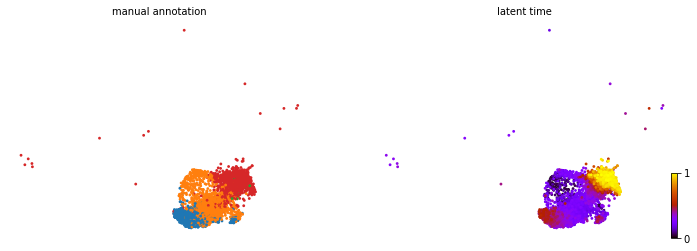

In [39]:
import scvelo as scv
scv.pl.scatter(adata21, color=['manual_annotation','latent_time'], cmap='gnuplot',)

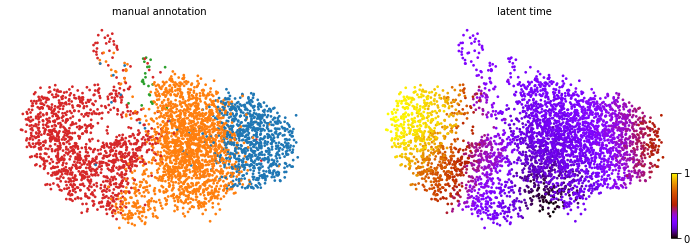

In [37]:
scv.pl.scatter(adata2, color=['manual_annotation','latent_time'], cmap='gnuplot',)

In [40]:
adata22=adata21.copy()

In [42]:
import scanpy as sc
sc.pp.highly_variable_genes(adata22, n_top_genes=10000, flavor="seurat_v3")
adata22=adata22[:,adata22.var['highly_variable']==True]
adata22

View of AnnData object with n_obs × n_vars = 3795 × 10000
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap', 'manual_annotation_colors'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [43]:
import scglue
scglue.data.lsi(adata22, n_components=100, n_iter=15)

In [87]:
import numpy as np
ran=np.random.choice(adata22.obs.index.tolist(),8*(len(adata22.obs.index.tolist())//10))
ran_r=list(set(adata22.obs.index.tolist())-set(ran))

X_train=adata22[ran].obsm['X_lsi']
Y_train=adata22.obs.loc[ran,'latent_time']
X_test=adata22[ran_r].obsm['X_lsi']
Y_test=adata22.obs.loc[ran_r,'latent_time']

In [88]:
model=creat_radio_model(100)
print('......lsi calculate',100)
print('......model fit',100)
history=model.fit(X_train, Y_train.values,
              batch_size=30,
              epochs=100,
              verbose=0,
              validation_data=(X_test, Y_test.values),callbacks=[tbCallBack])
#              callbacks=[cb],
#             callbacks=callbacks_list)
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

Model: "radio_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               51712     
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 577,537
Trainable params: 577,537
Non-trainable params: 0
_________________________________________________________________
None
......lsi calculate 100
......model fit 100


2022-07-04 02:23:20.687191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 02:23:21.424597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 02:24:26.543634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.003726434661075473, 0.042691923677921295]


In [89]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

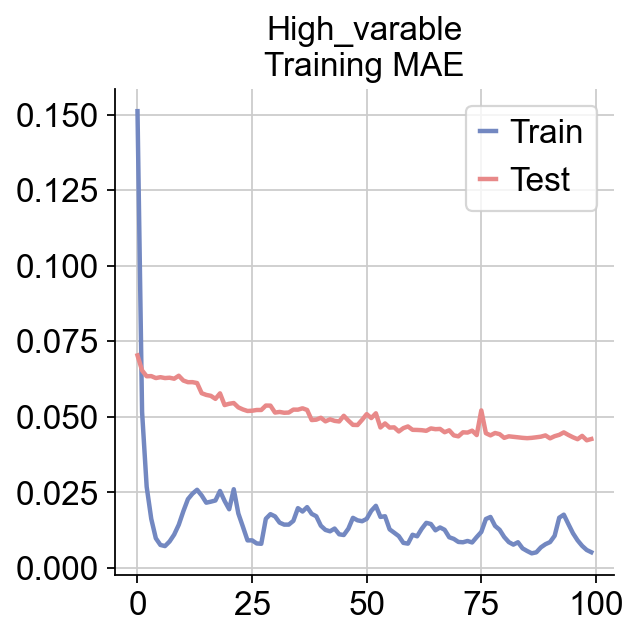

In [93]:
#定义图片大小
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

epochs=len(history.history['loss'])

plt.plot(range(epochs),history.history['mean_absolute_error'],
         label='Train',color='#7388c1',lw=2)
plt.plot(range(epochs),history.history['val_mean_absolute_error'],
         label='Test',color='#e88989',lw=2)

plt.legend(fontsize=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('High_varable\nTraining MAE',fontsize=15)
plt.savefig("figure/Fig2_h_gene_train.png".format(i),dpi=300,bbox_inches = 'tight')

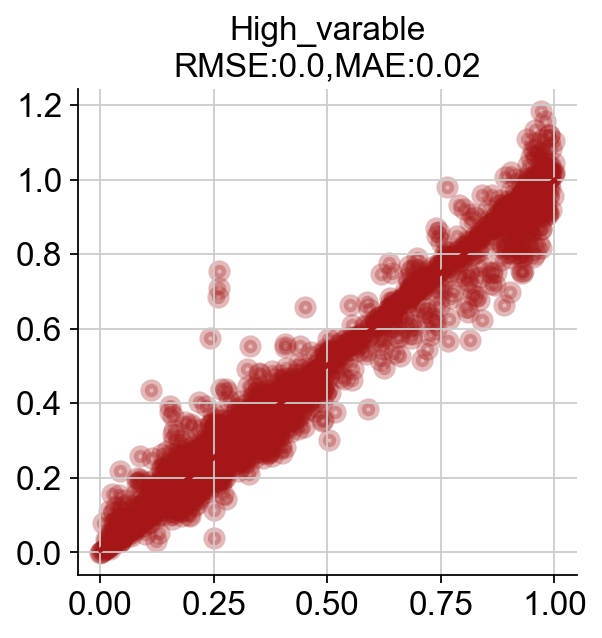

In [92]:
import seaborn as sns
X_val=adata22.obsm['X_lsi']
Y_val=adata22.obs['latent_time'].values
PredValSet=model.predict(X_val)

#定义图片大小
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

sns.regplot(x=Y_val, y=PredValSet.T[0],
    scatter_kws={'alpha':0.3,'linewidths':4},color='#a51616',ax=ax)

#设置横纵坐标轴字体
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

mae=round(mean_absolute_error(Y_val, PredValSet.T[0]),2)
mse=round(mean_squared_error(Y_val, PredValSet.T[0]),2)
#r2_score=round(r2_score(Y_val, PredValSet.T[0]),2)

plt.title('High_varable\nRMSE:{},MAE:{}'.format(mse,mae),fontsize=15)
plt.savefig("figure/Fig2_h_gene.png".format(i),dpi=300,bbox_inches = 'tight')

In [58]:
human_ret_gene=[]
with open('human_ret_gene.txt','r') as f:
    for i in f.readlines():
        human_ret_gene.append(i.replace('\n',''))
human_ret_gene[:10],len(human_ret_gene)

(['SEC22B',
  'ARPP19',
  'ZNF131',
  'CAPNS1',
  'PRPF19',
  'ZFP91',
  'TRIP12',
  'TANK',
  'JTB',
  'HDLBP'],
 3224)

In [59]:
adata23=adata21[:,human_ret_gene]
adata23

View of AnnData object with n_obs × n_vars = 3795 × 3224
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap', 'manual_annotation_colors'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [60]:
import scglue
scglue.data.lsi(adata23, n_components=100, n_iter=15)
sc.pp.normalize_total(adata23)
sc.pp.log1p(adata23)

In [94]:
import numpy as np
ran=np.random.choice(adata23.obs.index.tolist(),8*(len(adata23.obs.index.tolist())//10))
ran_r=list(set(adata23.obs.index.tolist())-set(ran))

X_train=adata23[ran].obsm['X_lsi']
Y_train=adata23.obs.loc[ran,'latent_time']
X_test=adata23[ran_r].obsm['X_lsi']
Y_test=adata23.obs.loc[ran_r,'latent_time']

In [95]:
model=creat_radio_model(100)
print('......lsi calculate',100)
print('......model fit',100)
history=model.fit(X_train, Y_train.values,
              batch_size=30,
              epochs=100,
              verbose=0,
              validation_data=(X_test, Y_test.values),callbacks=[tbCallBack])
#              callbacks=[cb],
#             callbacks=callbacks_list)
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

Model: "radio_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               51712     
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 1)                 513       
                                                                 
Total params: 577,537
Trainable params: 577,537
Non-trainable params: 0
_________________________________________________________________
None
......lsi calculate 100
......model fit 100


2022-07-04 02:33:25.580105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 02:33:26.319695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 02:34:35.804397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.04560529813170433, 0.14667759835720062]


In [74]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

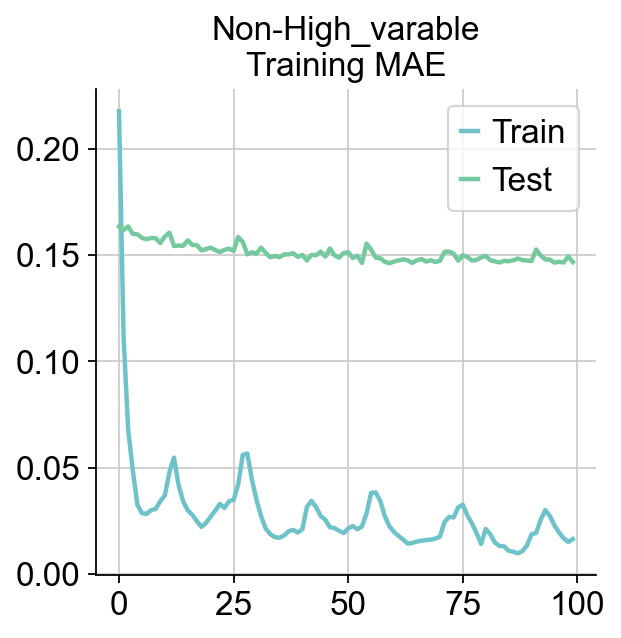

In [96]:
#定义图片大小
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

epochs=len(history.history['loss'])

plt.plot(range(epochs),history.history['mean_absolute_error'],
         label='Train',color='#6ec3c8',lw=2)
plt.plot(range(epochs),history.history['val_mean_absolute_error'],
         label='Test',color='#74c99f',lw=2)

plt.legend(fontsize=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Non-High_varable\nTraining MAE',fontsize=15)
plt.savefig("figure/Fig2_nh_gene_train.png".format(i),dpi=300,bbox_inches = 'tight')

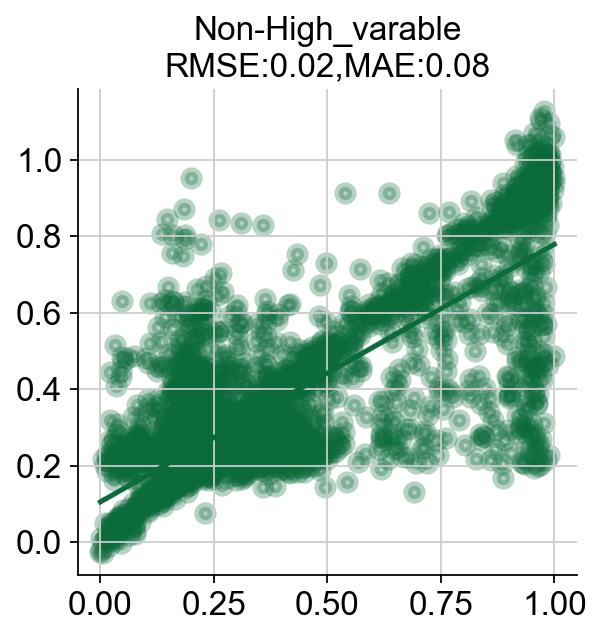

In [85]:
import seaborn as sns
X_val=adata23.obsm['X_lsi']
Y_val=adata23.obs['latent_time'].values
PredValSet=model.predict(X_val)

#定义图片大小
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

sns.regplot(x=Y_val, y=PredValSet.T[0],
    scatter_kws={'alpha':0.3,'linewidths':4},color='#0b6b3b',ax=ax)

#设置横纵坐标轴字体
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

mae=round(mean_absolute_error(Y_val, PredValSet.T[0]),2)
mse=round(mean_squared_error(Y_val, PredValSet.T[0]),2)
#r2_score=round(r2_score(Y_val, PredValSet.T[0]),2)

plt.title('Non-High_varable\nRMSE:{},MAE:{}'.format(mse,mae),fontsize=15)
plt.savefig("figure/Fig2_nh_gene.png".format(i),dpi=300,bbox_inches = 'tight')

(0.02196570537897266, 0.07883171864634216, 0.6440439978099496)